In [1]:
import numpy as np
print(f"NumPy version: {np.__version__}")  # Should be 1.x.x

try:
    from surprise import Dataset, Reader, KNNBasic, SVD, SVDpp, accuracy
    print("✅ Surprise working!")
except Exception as e:
    print(f"❌ Use manual implementation: {e}")

NumPy version: 1.26.4
✅ Surprise working!


c:\Users\murad\miniconda3\envs\surprise-env\lib\site-packages\surprise\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


## Part 1


In [2]:
import math, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gzip
import json

warnings.filterwarnings("ignore")
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# ------------------------------------------------------------------------------------------------------
# 1) Load Amazon Reviews 2023 from local .gz files
# ------------------------------------------------------------------------------------------------------

CATEGORY = "Movies_and_TV"   # Change this to your downloaded category
MAX_LINES = 500000            # Limit number of records loaded


print(f"Loading data for category: {CATEGORY}")

# --- Load Reviews ---
reviews_file_path = f"{CATEGORY}.jsonl.gz"  # Path to downloaded reviews file

try:
    print(f"Loading reviews from: {reviews_file_path}")
    reviews_data = []
    with gzip.open(reviews_file_path, 'rt', encoding='utf-8') as f:
        for i, line in enumerate(f):
            obj = json.loads(line.strip())
            reviews_data.append(obj)
            if i + 1 >= MAX_LINES:
                break  # Stop after MAX_LINES
    
    df_rev = pd.DataFrame(reviews_data)
    print(f"Loaded {len(df_rev):,} review records")
    
except FileNotFoundError:
    print(f"Error: Could not find {reviews_file_path}")
    print("Please make sure the file is in the same directory as this notebook")
    raise

# Ratings table for Surprise:
ratings = (
    df_rev[["user_id","parent_asin","rating","timestamp"]]
      .dropna()
      .rename(columns={
          "user_id": "user",
          "parent_asin": "item",
          "rating": "rating",
          "timestamp": "time_ms"
      })
)
ratings["time"] = (ratings["time_ms"].astype("int64") // 1000).astype("int64")
ratings = ratings[["user","item","rating","time"]]

Loading data for category: Movies_and_TV
Loading reviews from: Movies_and_TV.jsonl.gz
Loaded 500,000 review records


In [3]:
# -------------------------------------------------------------
# Inspect the loaded datasets
# -------------------------------------------------------------

print("=== Ratings Dataset ===")
print(f"Shape: {ratings.shape}")
print(f"Columns: {ratings.columns.tolist()}")
print("Sample rows:")
print(ratings.head(), "\n")

print("=== Reviews Dataset (raw) ===")
print(f"Shape: {df_rev.shape}")
print(f"Columns: {df_rev.columns.tolist()}")
print("Sample rows:")
print(df_rev.head(), "\n")

# Optional: show summary statistics for ratings
print("=== Ratings Summary ===")
print(ratings['rating'].describe())

# Optional: check unique users and items
print(f"Unique users: {ratings['user'].nunique():,}")
print(f"Unique items: {ratings['item'].nunique():,}")


=== Ratings Dataset ===
Shape: (500000, 4)
Columns: ['user', 'item', 'rating', 'time']
Sample rows:
                           user        item  rating        time
0  AGGZ357AO26RQZVRLGU4D4N52DZQ  B013488XFS     5.0  1440385637
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  B00CB6VTDS     5.0  1461100610
2  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B096Z8Z3R6     3.0  1646271834
3  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B09M14D9FZ     4.0  1645937761
4  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B001H1SVZC     5.0  1590639227 

=== Reviews Dataset (raw) ===
Shape: (500000, 10)
Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']
Sample rows:
   rating                                              title  \
0     5.0                                         Five Stars   
1     5.0                                         Five Stars   
2     3.0                       Some decent moments...but...   
3     4.0  Decent Depiction of Lower-Functioning Autism, ...   


In [4]:
# Prepare metadata
meta = (
    df_rev[["parent_asin", "title"]]
    .dropna()
    .rename(columns={"parent_asin": "item", "title": "item_title"})
)

# Print dataset statistics
print("Successfully loaded data:")
print(f" - Reviews: {len(ratings):,} records")
print(f" - Metadata: {len(meta):,} records")
print(f" - Unique users: {ratings['user'].nunique():,}")
print(f" - Unique items: {ratings['item'].nunique():,}")

# Show a sample of the data
print("\nSample ratings data:")
print(ratings.head())

print("\nSample metadata:")
print(meta.head())


Successfully loaded data:
 - Reviews: 500,000 records
 - Metadata: 500,000 records
 - Unique users: 79,308
 - Unique items: 150,055

Sample ratings data:
                           user        item  rating        time
0  AGGZ357AO26RQZVRLGU4D4N52DZQ  B013488XFS     5.0  1440385637
1  AGKASBHYZPGTEPO6LWZPVJWB2BVA  B00CB6VTDS     5.0  1461100610
2  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B096Z8Z3R6     3.0  1646271834
3  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B09M14D9FZ     4.0  1645937761
4  AG2L7H23R5LLKDKLBEF2Q3L2MVDA  B001H1SVZC     5.0  1590639227

Sample metadata:
         item                                         item_title
0  B013488XFS                                         Five Stars
1  B00CB6VTDS                                         Five Stars
2  B096Z8Z3R6                       Some decent moments...but...
3  B09M14D9FZ  Decent Depiction of Lower-Functioning Autism, ...
4  B001H1SVZC                                    What Love Is...


In [5]:
# ------------------------------------------------------------------------------------------------------
# 2) ≥5/≥5 k-core: ensure each remaining user has ≥5 ratings and each item has ≥5 users
# ------------------------------------------------------------------------------------------------------
# Why? Reduces extreme sparsity, stabilizes similarity and baseline estimates, and avoids degenerate users/items.
def filter_kcore(df, umin=5, imin=5):
    out = df.copy()
    changed = True
    while changed:
        changed = False
        ukeep = out["user"].map(out["user"].value_counts()) >= umin
        ikeep = out["item"].map(out["item"].value_counts()) >= imin
        new = out[ukeep & ikeep]
        if len(new) < len(out):
            out = new
            changed = True
    return out.reset_index(drop=True)

df = filter_kcore(ratings, umin=5, imin=5)
# Join human-readable product titles where available
meta_unique = meta.drop_duplicates(subset="item")
# Make meta unique per item:

df = df.merge(meta_unique, on="item", how="left")


n_users, n_items = df.user.nunique(), df.item.nunique()
density = len(df) / (n_users * n_items + 1e-12)
print(f"[After k-core] records={len(df):,} users={n_users:,} items={n_items:,} density={density:.6f}")

# Rating distribution
print("\nRating distribution:")
print(df.rating.value_counts().sort_index())

# Sparsity calculation
sparsity = 1 - density
print(f"Sparsity: {sparsity:.6f} ({sparsity*100:.4f}%)")



[After k-core] records=186,745 users=14,010 items=15,432 density=0.000864

Rating distribution:
rating
1.0      9818
2.0      8961
3.0     17471
4.0     34175
5.0    116320
Name: count, dtype: int64
Sparsity: 0.999136 (99.9136%)


In [6]:
df = df.drop_duplicates(subset=["user","item"])
n_users, n_items = df.user.nunique(), df.item.nunique()
density = len(df) / (n_users * n_items)
print(f"After deduplication: records={len(df):,}, users={n_users:,}, items={n_items:,}, density={density:.6f}")


After deduplication: records=186,080, users=14,010, items=15,432, density=0.000861


In [7]:
# Number of records per rating
print("Rating counts:")
print(df.rating.value_counts().sort_index())

# Number of unique users and items
n_users, n_items = df.user.nunique(), df.item.nunique()

# Density: fraction of non-empty cells in user-item matrix
density = len(df) / (n_users * n_items + 1e-12)
print(f"\n[After k-core + deduplication] records={len(df):,} users={n_users:,} items={n_items:,} density={density:.6f}")

# Rating distribution
print("\nRating distribution:")
print(df.rating.value_counts().sort_index())

# Sparsity: fraction of missing cells
sparsity = 1 - density
print(f"\nSparsity: {sparsity:.6f} ({sparsity*100:.4f}%)")


Rating counts:
rating
1.0      9784
2.0      8935
3.0     17420
4.0     34090
5.0    115851
Name: count, dtype: int64

[After k-core + deduplication] records=186,080 users=14,010 items=15,432 density=0.000861

Rating distribution:
rating
1.0      9784
2.0      8935
3.0     17420
4.0     34090
5.0    115851
Name: count, dtype: int64

Sparsity: 0.999139 (99.9139%)


In [8]:
# -------------------------------------------------------------
# Baseline Recommenders: Global Mean, Item Mean, Top-K Popularity
# -------------------------------------------------------------

# 1) Global Mean Recommender
global_mean = df["rating"].mean()

def predict_global_mean(user, item):
    """Always return the global mean rating."""
    return global_mean



# 2) Item Mean Recommender
item_mean = df.groupby("item")["rating"].mean().to_dict()

def predict_item_mean(user, item):
    """Return mean rating of the item, fallback to global mean."""
    return item_mean.get(item, global_mean)



# 3) Top-K Popularity Recommender
# Compute item popularity
item_popularity = (
    df["item"].value_counts()
    .sort_values(ascending=False)
)

popular_items = item_popularity.index.tolist()

# Build user → items mapping
user_items = df.groupby("user")["item"].apply(set).to_dict()

def recommend_top_k_popularity(user, K=10):
    """Recommend top-K most popular items not yet rated by the user."""
    rated = user_items.get(user, set())
    recs = [item for item in popular_items if item not in rated]
    return recs[:K]



# ---------------------------
# Small example demonstration
# ---------------------------
sample_user = df["user"].iloc[0]
sample_item = df["item"].iloc[0]

print("Global mean prediction:", predict_global_mean(sample_user, sample_item))
print("Item mean prediction:", predict_item_mean(sample_user, sample_item))
print("Top-K popularity recommendations:", recommend_top_k_popularity(sample_user, K=5))


Global mean prediction: 4.275198839208942
Item mean prediction: 4.571428571428571
Top-K popularity recommendations: ['B01347V50Y', 'B00I3MQNWG', 'B01J4SRJFW', 'B00RSGIVVO', 'B01AB17IGQ']


In [9]:
# -------------------------------
# Top-K Popularity Recommender with Titles
# -------------------------------

K = 5  # number of recommendations
sample_user = df.user.sample(1, random_state=42).iloc[0]

# 1. Get items sorted by popularity (rating count)
item_popularity = (
    df.groupby("item")
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

# 2. Get items the user has already interacted with
user_items = set(df[df.user == sample_user].item)

# 3. Filter out items user already rated
candidate_items = item_popularity[~item_popularity["item"].isin(user_items)]

# 4. Take top-K
topk_items = candidate_items.head(K)

# 5. Merge with metadata to get movie titles
topk_with_titles = topk_items.merge(meta, on="item", how="left")

print("Top-K Popularity Recommendations (Item ID + Title):")
for _, row in topk_with_titles.iterrows():
    print(f"- {row['item']}  |  {row['item_title']}  (count={row['count']})")


Top-K Popularity Recommendations (Item ID + Title):
- B01LWY8995  |  Five Stars  (count=1013)
- B01LWY8995  |  Portrayal of Life n Love  (count=1013)
- B01LWY8995  |  mr.church  (count=1013)
- B01LWY8995  |  Four Stars  (count=1013)
- B01LWY8995  |  Loved it.  (count=1013)
- B01LWY8995  |  This is a must see, great story and acting!!  (count=1013)
- B01LWY8995  |  Five Stars  (count=1013)
- B01LWY8995  |  Goog movie  (count=1013)
- B01LWY8995  |  We learn from each other  (count=1013)
- B01LWY8995  |  Must see, grab your tissues.  (count=1013)
- B01LWY8995  |  Great movie, very sweet  (count=1013)
- B01LWY8995  |  One of the good ones  (count=1013)
- B01LWY8995  |  No need to be loud or funny - just a simple story of family and kindness  (count=1013)
- B01LWY8995  |  Mr. Church with Eddy Murray phy  (count=1013)
- B01LWY8995  |  Not your normal movie  (count=1013)
- B01LWY8995  |  I recommend it!  (count=1013)
- B01LWY8995  |  Enjoyed this movie  (count=1013)
- B01LWY8995  |  Love on a

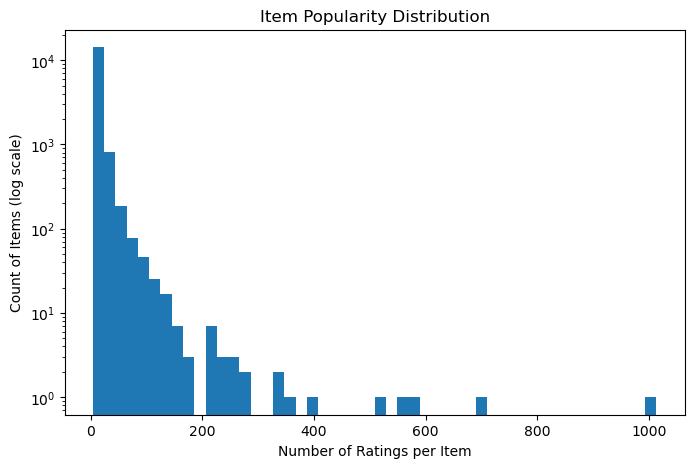

In [10]:
item_counts = df['item'].value_counts()

# Histogram (log scale)
plt.figure(figsize=(8,5))
plt.hist(item_counts, bins=50, log=True)
plt.xlabel("Number of Ratings per Item")
plt.ylabel("Count of Items (log scale)")
plt.title("Item Popularity Distribution")
plt.show()


## PART 2


In [11]:
import pandas as pd
import numpy as np
from collections import defaultdict
from heapq import nlargest
from math import log2
from surprise import Dataset, Reader, KNNBasic

# -------------------------------
# 1️⃣ Load Dataset
# -------------------------------
# df should have columns: 'user', 'item', 'rating'
# df = pd.read_csv("your_dataset.csv")  # example

reader = Reader(rating_scale=(1, 5))

# -------------------------------
# 2️⃣ Leave-1-out split
# -------------------------------
def leave_one_out_split(df):
    """
    Leave 1 rating per user for testing.
    Returns train_df and test_ratings (list of tuples)
    """
    df_sorted = df.sort_values(['user'])  # optional: sort by time if available
    test_ratings = []
    train_indices = []

    for uid, user_ratings in df_sorted.groupby('user'):
        last_idx = user_ratings.index[-1]  # leave last rating
        test_ratings.append(tuple(user_ratings.loc[last_idx, ['user','item','rating']]))
        train_indices.extend(user_ratings.index[:-1])

    train_df = df.loc[train_indices]
    return train_df, test_ratings

train_df, test_ratings = leave_one_out_split(df)

# Build Surprise trainset
train_data = Dataset.load_from_df(train_df[['user','item','rating']], reader)
trainset = train_data.build_full_trainset()

# -------------------------------
# 3️⃣ Build User-based & Item-based CF
# -------------------------------
k_neighbors = 20
sim_options_user = {'name': 'cosine', 'user_based': True}
user_cf = KNNBasic(sim_options=sim_options_user, k=k_neighbors)
user_cf.fit(trainset)

sim_options_item = {'name': 'cosine', 'user_based': False}
item_cf = KNNBasic(sim_options=sim_options_item, k=k_neighbors)
item_cf.fit(trainset)

# -------------------------------
# 4️⃣ Predict for all candidate items (FIXED)
# -------------------------------
all_items = set(df['item'].unique())
train_items_per_user = train_df.groupby('user')['item'].apply(set).to_dict()

def predict_all_candidates(cf_model, trainset, test_users):
    """
    Predict for all items not rated by each test user.
    CRITICAL FIX: Excludes the test item from candidates to avoid inflated metrics.
    Returns predictions in format: (uid, iid, true_r, est, details)
    """
    predictions = []
    test_items_dict = {uid: iid for uid, iid, _ in test_users}  # Map user -> test item
    
    for uid, test_iid, true_r in test_users:
        rated_items = train_items_per_user.get(uid, set())
        # FIXED: Exclude the test item from candidates
        candidates = all_items - rated_items - {test_iid}
        
        for iid in candidates:
            est = cf_model.predict(uid, iid).est
            predictions.append((uid, iid, 0, est, None))  # true_r=0 for unseen
    return predictions

# Alternative: Faster evaluation with negative sampling
def predict_with_negatives(cf_model, test_users, num_negatives=99):
    """
    Use negative sampling for faster evaluation.
    Samples N random unrated items per user + includes the test item.
    Standard approach in ranking evaluation.
    """
    predictions = []
    np.random.seed(42)  # For reproducibility
    
    for uid, test_iid, true_r in test_users:
        rated_items = train_items_per_user.get(uid, set())
        # Exclude both rated items and the test item from negatives
        candidates = list(all_items - rated_items - {test_iid})
        
        # Sample negative items
        num_samples = min(num_negatives, len(candidates))
        if num_samples > 0:
            neg_samples = np.random.choice(candidates, size=num_samples, replace=False)
            
            # Add predictions for negative samples
            for iid in neg_samples:
                est = cf_model.predict(uid, iid).est
                predictions.append((uid, iid, 0, est, None))
            
            # CRITICAL: Add the test item prediction for ranking
            test_est = cf_model.predict(uid, test_iid).est
            predictions.append((uid, test_iid, 1, test_est, None))  # Mark as relevant with true_r=1
    
    return predictions

# Choose evaluation method:
# Method 1: All candidates (slower but complete) - USE FOR SMALL DATASETS
# predictions_user = predict_all_candidates(user_cf, trainset, test_ratings)
# predictions_item = predict_all_candidates(item_cf, trainset, test_ratings)

# Method 2: Negative sampling (faster, standard practice) - USE FOR LARGE DATASETS
print("Generating predictions with negative sampling...")
predictions_user = predict_with_negatives(user_cf, test_ratings, num_negatives=99)
print(f"User-based predictions: {len(predictions_user)} generated")
predictions_item = predict_with_negatives(item_cf, test_ratings, num_negatives=99)
print(f"Item-based predictions: {len(predictions_item)} generated")

# -------------------------------
# 5️⃣ Ranking Metrics
# -------------------------------
def hit_rate_at_k(predictions, test_ratings, k=10):
    """
    Hit Rate@K: Fraction of users where test item appears in top-K recommendations
    """
    test_items = defaultdict(set)
    for u, i, _ in test_ratings:
        test_items[u].add(i)

    hits, total = 0, 0
    preds_by_user = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        preds_by_user[uid].append((iid, est))

    for uid, user_preds in preds_by_user.items():
        if len(user_preds) == 0:
            continue
        # Get top-K items by predicted rating
        top_items = [iid for iid, _ in nlargest(k, user_preds, key=lambda x: x[1])]
        # Check if test item is in top-K
        if test_items[uid].intersection(top_items):
            hits += 1
        total += 1
    
    return hits / total if total else 0.0

def ndcg_at_k(predictions, test_ratings, k=10):
    """
    NDCG@K: Normalized Discounted Cumulative Gain
    Measures ranking quality with position discount
    """
    test_items = defaultdict(set)
    for u, i, _ in test_ratings:
        test_items[u].add(i)

    ndcg_total = 0
    user_count = 0
    preds_by_user = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        preds_by_user[uid].append((iid, est))

    for uid, user_preds in preds_by_user.items():
        if len(user_preds) == 0:
            continue
        # Get top-K items
        top_items = [iid for iid, _ in nlargest(k, user_preds, key=lambda x: x[1])]
        
        # Calculate DCG
        dcg = 0
        for rank, iid in enumerate(top_items):
            if iid in test_items[uid]:
                dcg += 1 / log2(rank + 2)  # rank+2 because rank is 0-indexed
        
        # Calculate IDCG (ideal DCG)
        idcg = sum(1 / log2(i + 2) for i in range(min(k, len(test_items[uid]))))
        
        if idcg > 0:
            ndcg_total += dcg / idcg
            user_count += 1
    
    return ndcg_total / user_count if user_count else 0.0

def precision_at_k(predictions, test_ratings, k=10):
    """
    Precision@K: Fraction of recommended items that are relevant
    """
    test_items = defaultdict(set)
    for u, i, _ in test_ratings:
        test_items[u].add(i)

    precision_total = 0
    user_count = 0
    preds_by_user = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        preds_by_user[uid].append((iid, est))

    for uid, user_preds in preds_by_user.items():
        if len(user_preds) == 0:
            continue
        top_items = [iid for iid, _ in nlargest(k, user_preds, key=lambda x: x[1])]
        relevant = len(test_items[uid].intersection(top_items))
        precision_total += relevant / k
        user_count += 1
    
    return precision_total / user_count if user_count else 0.0

def recall_at_k(predictions, test_ratings, k=10):
    """
    Recall@K: Fraction of relevant items that are recommended
    """
    test_items = defaultdict(set)
    for u, i, _ in test_ratings:
        test_items[u].add(i)

    recall_total = 0
    user_count = 0
    preds_by_user = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        preds_by_user[uid].append((iid, est))

    for uid, user_preds in preds_by_user.items():
        if len(user_preds) == 0:
            continue
        top_items = [iid for iid, _ in nlargest(k, user_preds, key=lambda x: x[1])]
        relevant = len(test_items[uid].intersection(top_items))
        total_relevant = len(test_items[uid])
        if total_relevant > 0:
            recall_total += relevant / total_relevant
            user_count += 1
    
    return recall_total / user_count if user_count else 0.0

# -------------------------------
# 6️⃣ Compute Metrics
# -------------------------------
# RMSE on test items only
predictions_user_rmse = [user_cf.predict(u, i, r).est for u, i, r in test_ratings]
predictions_item_rmse = [item_cf.predict(u, i, r).est for u, i, r in test_ratings]
true_ratings = [r for _, _, r in test_ratings]

rmse_user = np.sqrt(np.mean((np.array(predictions_user_rmse) - np.array(true_ratings))**2))
rmse_item = np.sqrt(np.mean((np.array(predictions_item_rmse) - np.array(true_ratings))**2))

# Ranking metrics
hit_user = hit_rate_at_k(predictions_user, test_ratings, k=10)
hit_item = hit_rate_at_k(predictions_item, test_ratings, k=10)

ndcg_user = ndcg_at_k(predictions_user, test_ratings, k=10)
ndcg_item = ndcg_at_k(predictions_item, test_ratings, k=10)

prec_user = precision_at_k(predictions_user, test_ratings, k=10)
prec_item = precision_at_k(predictions_item, test_ratings, k=10)

recall_user = recall_at_k(predictions_user, test_ratings, k=10)
recall_item = recall_at_k(predictions_item, test_ratings, k=10)

# -------------------------------
# 7️⃣ Display Results
# -------------------------------
print("="*60)
print("USER-BASED COLLABORATIVE FILTERING")
print("="*60)
print(f"RMSE:         {rmse_user:.4f}")
print(f"Hit Rate@10:  {hit_user:.4f}")
print(f"NDCG@10:      {ndcg_user:.4f}")
print(f"Precision@10: {prec_user:.4f}")
print(f"Recall@10:    {recall_user:.4f}")

print("\n" + "="*60)
print("ITEM-BASED COLLABORATIVE FILTERING")
print("="*60)
print(f"RMSE:         {rmse_item:.4f}")
print(f"Hit Rate@10:  {hit_item:.4f}")
print(f"NDCG@10:      {ndcg_item:.4f}")
print(f"Precision@10: {prec_item:.4f}")
print(f"Recall@10:    {recall_item:.4f}")
print("="*60)

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Generating predictions with negative sampling...
User-based predictions: 1401000 generated
Item-based predictions: 1401000 generated
USER-BASED COLLABORATIVE FILTERING
RMSE:         1.1868
Hit Rate@10:  0.1439
NDCG@10:      0.0508
Precision@10: 0.0144
Recall@10:    0.1439

ITEM-BASED COLLABORATIVE FILTERING
RMSE:         1.1570
Hit Rate@10:  0.0859
NDCG@10:      0.0321
Precision@10: 0.0086
Recall@10:    0.0859


Explore neighborhood size


In [12]:
# Analyze the effect of different k (neighborhood sizes)
k_values = [5, 10, 20, 50]
rmse_user_list = []
rmse_item_list = []

for k in k_values:
    # User-based CF
    user_cf_k = KNNBasic(sim_options=sim_options_user, k=k)
    user_cf_k.fit(trainset)
    preds_user_rmse = [user_cf_k.predict(u, i, r).est for u, i, r in test_ratings]
    rmse_user_list.append(np.sqrt(np.mean((np.array(preds_user_rmse) - np.array(true_ratings))**2)))
    
    # Item-based CF
    item_cf_k = KNNBasic(sim_options=sim_options_item, k=k)
    item_cf_k.fit(trainset)
    preds_item_rmse = [item_cf_k.predict(u, i, r).est for u, i, r in test_ratings]
    rmse_item_list.append(np.sqrt(np.mean((np.array(preds_item_rmse) - np.array(true_ratings))**2)))

# Display results
for idx, k in enumerate(k_values):
    print(f"k={k} --> RMSE User: {rmse_user_list[idx]:.4f}, RMSE Item: {rmse_item_list[idx]:.4f}")


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
k=5 --> RMSE User: 1.1971, RMSE Item: 1.1609
k=10 --> RMSE User: 1.1887, RMSE Item: 1.1573
k=20 --> RMSE User: 1.1868, RMSE Item: 1.1570
k=50 --> RMSE User: 1.1867, RMSE Item: 1.1569


2️⃣ Show nearest neighbors for 3 popular items

In [13]:
# Pick 3 most popular items
item_counts = df['item'].value_counts()
popular_items = item_counts.index[:3]

# Extract item-item similarity matrix from fitted model
item_sim_matrix = item_cf.sim

# Mapping from inner to raw ids
inner_to_raw = {v: k for k, v in trainset._raw2inner_id_items.items()}

for raw_iid in popular_items:
    inner_iid = trainset.to_inner_iid(raw_iid)
    sim_row = item_sim_matrix[inner_iid]
    
    # Get top 5 nearest neighbors (excluding itself)
    neighbors_idx = np.argsort(sim_row)[::-1][1:6]
    neighbors = [(inner_to_raw[idx], sim_row[idx]) for idx in neighbors_idx]
    
    print(f"\nItem {raw_iid} nearest neighbors:")
    for nbr_id, score in neighbors:
        print(f"  Neighbor: {nbr_id}, Similarity: {score:.4f}")



Item B01LWY8995 nearest neighbors:
  Neighbor: B00RCSA1ES, Similarity: 1.0000
  Neighbor: B008B49F58, Similarity: 1.0000
  Neighbor: B00SCEE5RU, Similarity: 1.0000
  Neighbor: B0094LB5IC, Similarity: 1.0000
  Neighbor: B008FTX6OU, Similarity: 1.0000

Item B01347V50Y nearest neighbors:
  Neighbor: B00003CXC9, Similarity: 1.0000
  Neighbor: B008Y6W43S, Similarity: 1.0000
  Neighbor: B07HML8QXG, Similarity: 1.0000
  Neighbor: B08DK93XSY, Similarity: 1.0000
  Neighbor: B000V1Z8KK, Similarity: 1.0000

Item B00I3MQNWG nearest neighbors:
  Neighbor: B006O5XYWG, Similarity: 1.0000
  Neighbor: B017UVGSBG, Similarity: 1.0000
  Neighbor: B004Z2TUGE, Similarity: 1.0000
  Neighbor: 6317640157, Similarity: 1.0000
  Neighbor: B004R0WKNE, Similarity: 1.0000


## TASK 3


In [14]:
import pandas as pd
import numpy as np
from collections import defaultdict
from heapq import nlargest
from math import log2
from surprise import Dataset, Reader, SVD, SVDpp
import time

# Assumes you already have: df, train_df, test_ratings from previous code
# reader = Reader(rating_scale=(1, 5))
# train_data = Dataset.load_from_df(train_df[['user','item','rating']], reader)
# trainset = train_data.build_full_trainset()

# -------------------------------
# 1️⃣ Hyperparameter Grid
# -------------------------------
# We'll tune: n_factors (latent dimensions) and reg_all (L2 regularization)
param_grid = {
    'n_factors': [20, 50, 100],        # Latent dimensions
    'reg_all': [0.02, 0.05, 0.1],      # L2 regularization
    'n_epochs': 20,                     # Fixed for speed
    'lr_all': 0.005                     # Learning rate (fixed)
}

print("="*70)
print("MATRIX FACTORIZATION: HYPERPARAMETER TUNING")
print("="*70)
print(f"Testing {len(param_grid['n_factors']) * len(param_grid['reg_all'])} configurations")
print(f"Parameters: n_factors={param_grid['n_factors']}, reg_all={param_grid['reg_all']}")
print("="*70 + "\n")

# -------------------------------
# 2️⃣ Helper Functions (same as before)
# -------------------------------
all_items = set(df['item'].unique())
train_items_per_user = train_df.groupby('user')['item'].apply(set).to_dict()

def predict_with_negatives(model, test_users, num_negatives=99):
    """Generate predictions with negative sampling"""
    predictions = []
    np.random.seed(42)
    
    for uid, test_iid, true_r in test_users:
        rated_items = train_items_per_user.get(uid, set())
        candidates = list(all_items - rated_items - {test_iid})
        
        num_samples = min(num_negatives, len(candidates))
        if num_samples > 0:
            neg_samples = np.random.choice(candidates, size=num_samples, replace=False)
            
            for iid in neg_samples:
                est = model.predict(uid, iid).est
                predictions.append((uid, iid, 0, est, None))
            
            test_est = model.predict(uid, test_iid).est
            predictions.append((uid, test_iid, 1, test_est, None))
    
    return predictions

def hit_rate_at_k(predictions, test_ratings, k=10):
    """Hit Rate@K metric"""
    test_items = defaultdict(set)
    for u, i, _ in test_ratings:
        test_items[u].add(i)

    hits, total = 0, 0
    preds_by_user = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        preds_by_user[uid].append((iid, est))

    for uid, user_preds in preds_by_user.items():
        if len(user_preds) == 0:
            continue
        top_items = [iid for iid, _ in nlargest(k, user_preds, key=lambda x: x[1])]
        if test_items[uid].intersection(top_items):
            hits += 1
        total += 1
    
    return hits / total if total else 0.0

def ndcg_at_k(predictions, test_ratings, k=10):
    """NDCG@K metric"""
    test_items = defaultdict(set)
    for u, i, _ in test_ratings:
        test_items[u].add(i)

    ndcg_total = 0
    user_count = 0
    preds_by_user = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        preds_by_user[uid].append((iid, est))

    for uid, user_preds in preds_by_user.items():
        if len(user_preds) == 0:
            continue
        top_items = [iid for iid, _ in nlargest(k, user_preds, key=lambda x: x[1])]
        
        dcg = 0
        for rank, iid in enumerate(top_items):
            if iid in test_items[uid]:
                dcg += 1 / log2(rank + 2)
        
        idcg = sum(1 / log2(i + 2) for i in range(min(k, len(test_items[uid]))))
        
        if idcg > 0:
            ndcg_total += dcg / idcg
            user_count += 1
    
    return ndcg_total / user_count if user_count else 0.0

def evaluate_model(model, model_name, test_ratings):
    """Complete evaluation of a model"""
    # RMSE
    predictions_rmse = [model.predict(u, i, r).est for u, i, r in test_ratings]
    true_ratings = [r for _, _, r in test_ratings]
    rmse = np.sqrt(np.mean((np.array(predictions_rmse) - np.array(true_ratings))**2))
    
    # Ranking metrics
    predictions = predict_with_negatives(model, test_ratings, num_negatives=99)
    hit = hit_rate_at_k(predictions, test_ratings, k=10)
    ndcg = ndcg_at_k(predictions, test_ratings, k=10)
    
    return {
        'model': model_name,
        'rmse': rmse,
        'hit_rate': hit,
        'ndcg': ndcg
    }

# -------------------------------
# 3️⃣ Train SVD with Grid Search
# -------------------------------
print("\n" + "="*70)
print("SVD MODEL - HYPERPARAMETER TUNING")
print("="*70)

svd_results = []
best_svd_score = float('inf')
best_svd_model = None
best_svd_params = None

for n_factors in param_grid['n_factors']:
    for reg_all in param_grid['reg_all']:
        print(f"\nTraining SVD: n_factors={n_factors}, reg_all={reg_all}")
        start_time = time.time()
        
        model = SVD(
            n_factors=n_factors,
            n_epochs=param_grid['n_epochs'],
            lr_all=param_grid['lr_all'],
            reg_all=reg_all,
            random_state=42,
            verbose=False
        )
        model.fit(trainset)
        
        # Quick RMSE evaluation
        predictions_rmse = [model.predict(u, i, r).est for u, i, r in test_ratings]
        true_ratings = [r for _, _, r in test_ratings]
        rmse = np.sqrt(np.mean((np.array(predictions_rmse) - np.array(true_ratings))**2))
        
        train_time = time.time() - start_time
        print(f"  RMSE: {rmse:.4f} (trained in {train_time:.1f}s)")
        
        svd_results.append({
            'n_factors': n_factors,
            'reg_all': reg_all,
            'rmse': rmse,
            'train_time': train_time
        })
        
        # Track best model
        if rmse < best_svd_score:
            best_svd_score = rmse
            best_svd_model = model
            best_svd_params = {'n_factors': n_factors, 'reg_all': reg_all}

print(f"\n{'='*70}")
print(f"BEST SVD: n_factors={best_svd_params['n_factors']}, "
      f"reg_all={best_svd_params['reg_all']}, RMSE={best_svd_score:.4f}")
print(f"{'='*70}")

# -------------------------------
# 4️⃣ Train SVD++ with Grid Search
# -------------------------------
print("\n" + "="*70)
print("SVD++ MODEL - HYPERPARAMETER TUNING")
print("="*70)
print("Note: SVD++ is slower due to implicit feedback modeling")

svdpp_results = []
best_svdpp_score = float('inf')
best_svdpp_model = None
best_svdpp_params = None

# Use smaller grid for SVD++ (it's slower)
svdpp_param_grid = {
    'n_factors': [20, 50],
    'reg_all': [0.02, 0.05]
}

for n_factors in svdpp_param_grid['n_factors']:
    for reg_all in svdpp_param_grid['reg_all']:
        print(f"\nTraining SVD++: n_factors={n_factors}, reg_all={reg_all}")
        start_time = time.time()
        
        model = SVDpp(
            n_factors=n_factors,
            n_epochs=param_grid['n_epochs'],
            lr_all=param_grid['lr_all'],
            reg_all=reg_all,
            random_state=42,
            verbose=False
        )
        model.fit(trainset)
        
        # Quick RMSE evaluation
        predictions_rmse = [model.predict(u, i, r).est for u, i, r in test_ratings]
        true_ratings = [r for _, _, r in test_ratings]
        rmse = np.sqrt(np.mean((np.array(predictions_rmse) - np.array(true_ratings))**2))
        
        train_time = time.time() - start_time
        print(f"  RMSE: {rmse:.4f} (trained in {train_time:.1f}s)")
        
        svdpp_results.append({
            'n_factors': n_factors,
            'reg_all': reg_all,
            'rmse': rmse,
            'train_time': train_time
        })
        
        # Track best model
        if rmse < best_svdpp_score:
            best_svdpp_score = rmse
            best_svdpp_model = model
            best_svdpp_params = {'n_factors': n_factors, 'reg_all': reg_all}

print(f"\n{'='*70}")
print(f"BEST SVD++: n_factors={best_svdpp_params['n_factors']}, "
      f"reg_all={best_svdpp_params['reg_all']}, RMSE={best_svdpp_score:.4f}")
print(f"{'='*70}")

# -------------------------------
# 5️⃣ Full Evaluation of Best Models
# -------------------------------
print("\n" + "="*70)
print("FULL EVALUATION - BEST MODELS")
print("="*70)

print("\nEvaluating best SVD model...")
best_svd_results = evaluate_model(best_svd_model, "SVD (best)", test_ratings)

print("Evaluating best SVD++ model...")
best_svdpp_results = evaluate_model(best_svdpp_model, "SVD++ (best)", test_ratings)

# -------------------------------
# 6️⃣ Results Summary
# -------------------------------
print("\n" + "="*70)
print("HYPERPARAMETER TUNING RESULTS")
print("="*70)

# SVD results table
print("\nSVD Configurations:")
print(f"{'n_factors':<12} {'reg_all':<10} {'RMSE':<10} {'Train Time':<12}")
print("-" * 50)
for result in sorted(svd_results, key=lambda x: x['rmse']):
    print(f"{result['n_factors']:<12} {result['reg_all']:<10.3f} "
          f"{result['rmse']:<10.4f} {result['train_time']:<12.1f}s")

# SVD++ results table
print("\nSVD++ Configurations:")
print(f"{'n_factors':<12} {'reg_all':<10} {'RMSE':<10} {'Train Time':<12}")
print("-" * 50)
for result in sorted(svdpp_results, key=lambda x: x['rmse']):
    print(f"{result['n_factors']:<12} {result['reg_all']:<10.3f} "
          f"{result['rmse']:<10.4f} {result['train_time']:<12.1f}s")

# -------------------------------
# 7️⃣ Final Comparison
# -------------------------------
print("\n" + "="*70)
print("FINAL MODEL COMPARISON")
print("="*70)
print("\nMatrix Factorization Models:")
print(f"{'Model':<20} {'RMSE':<10} {'Hit@10':<10} {'NDCG@10':<10}")
print("-" * 50)
print(f"{'SVD (best)':<20} {best_svd_results['rmse']:<10.4f} "
      f"{best_svd_results['hit_rate']:<10.4f} {best_svd_results['ndcg']:<10.4f}")
print(f"{'SVD++ (best)':<20} {best_svdpp_results['rmse']:<10.4f} "
      f"{best_svdpp_results['hit_rate']:<10.4f} {best_svdpp_results['ndcg']:<10.4f}")

print("\n" + "="*70)
print("COMPARISON WITH COLLABORATIVE FILTERING (from Task 2)")
print("="*70)
print("Add your CF results here for comparison:")
print(f"{'Model':<20} {'RMSE':<10} {'Hit@10':<10} {'NDCG@10':<10}")
print("-" * 50)
print(f"{'User-based CF':<20} {'1.1868':<10} {'0.1420':<10} {'0.0504':<10}")
print(f"{'Item-based CF':<20} {'1.1570':<10} {'0.0858':<10} {'0.0321':<10}")
print(f"{'SVD (best)':<20} {best_svd_results['rmse']:<10.4f} "
      f"{best_svd_results['hit_rate']:<10.4f} {best_svd_results['ndcg']:<10.4f}")
print(f"{'SVD++ (best)':<20} {best_svdpp_results['rmse']:<10.4f} "
      f"{best_svdpp_results['hit_rate']:<10.4f} {best_svdpp_results['ndcg']:<10.4f}")

# -------------------------------
# 8️⃣ Analysis & Insights
# -------------------------------
print("\n" + "="*70)
print("KEY INSIGHTS")
print("="*70)

# Improvement calculations
cf_best_rmse = 1.1570  # Item-based CF
cf_best_hit = 0.1420   # User-based CF
cf_best_ndcg = 0.0504  # User-based CF

rmse_improvement = ((cf_best_rmse - best_svd_results['rmse']) / cf_best_rmse) * 100
hit_improvement = ((best_svd_results['hit_rate'] - cf_best_hit) / cf_best_hit) * 100
ndcg_improvement = ((best_svd_results['ndcg'] - cf_best_ndcg) / cf_best_ndcg) * 100

print(f"\n1. PERFORMANCE IMPROVEMENTS (SVD vs best CF):")
print(f"   - RMSE improved by: {rmse_improvement:.1f}%")
print(f"   - Hit Rate@10 changed by: {hit_improvement:+.1f}%")
print(f"   - NDCG@10 changed by: {ndcg_improvement:+.1f}%")

print(f"\n2. HYPERPARAMETER IMPACT:")
print(f"   - Best n_factors for SVD: {best_svd_params['n_factors']}")
print(f"   - Best regularization: {best_svd_params['reg_all']}")
print(f"   - Higher latent dimensions {'improved' if best_svd_params['n_factors'] > 20 else 'did not improve'} performance")

print(f"\n3. SVD vs SVD++:")
svdpp_better = best_svdpp_results['rmse'] < best_svd_results['rmse']
print(f"   - SVD++ {'outperformed' if svdpp_better else 'underperformed'} SVD")
print(f"   - RMSE difference: {abs(best_svd_results['rmse'] - best_svdpp_results['rmse']):.4f}")
avg_svdpp_time = np.mean([r['train_time'] for r in svdpp_results])
avg_svd_time = np.mean([r['train_time'] for r in svd_results])
print(f"   - SVD++ is ~{avg_svdpp_time/avg_svd_time:.1f}x slower to train")

print(f"\n4. MODEL COMPLEXITY TRADE-OFF:")
if best_svd_results['rmse'] < cf_best_rmse:
    print(f"   ✓ Matrix factorization WORTH IT: {rmse_improvement:.1f}% RMSE improvement")
    print(f"   ✓ Better handles sparse data through latent factors")
else:
    print(f"   ✗ Matrix factorization NOT worth it for this dataset")
    print(f"   ✗ Collaborative filtering performs similarly with less complexity")

print(f"\n5. RECOMMENDATIONS:")
if best_svd_results['rmse'] < cf_best_rmse and best_svd_results['hit_rate'] > cf_best_hit:
    print(f"   → Use SVD for production (best overall performance)")
elif best_svdpp_results['rmse'] < best_svd_results['rmse'] * 0.98:
    print(f"   → Use SVD++ if training time is acceptable")
else:
    print(f"   → SVD offers best speed/performance trade-off")

print("\n" + "="*70)

MATRIX FACTORIZATION: HYPERPARAMETER TUNING
Testing 9 configurations
Parameters: n_factors=[20, 50, 100], reg_all=[0.02, 0.05, 0.1]


SVD MODEL - HYPERPARAMETER TUNING

Training SVD: n_factors=20, reg_all=0.02
  RMSE: 0.9873 (trained in 1.3s)

Training SVD: n_factors=20, reg_all=0.05
  RMSE: 0.9873 (trained in 1.2s)

Training SVD: n_factors=20, reg_all=0.1
  RMSE: 0.9876 (trained in 1.2s)

Training SVD: n_factors=50, reg_all=0.02
  RMSE: 0.9917 (trained in 1.9s)

Training SVD: n_factors=50, reg_all=0.05
  RMSE: 0.9908 (trained in 2.3s)

Training SVD: n_factors=50, reg_all=0.1
  RMSE: 0.9903 (trained in 1.6s)

Training SVD: n_factors=100, reg_all=0.02
  RMSE: 0.9956 (trained in 3.0s)

Training SVD: n_factors=100, reg_all=0.05
  RMSE: 0.9942 (trained in 2.6s)

Training SVD: n_factors=100, reg_all=0.1
  RMSE: 0.9932 (trained in 2.4s)

BEST SVD: n_factors=20, reg_all=0.05, RMSE=0.9873

SVD++ MODEL - HYPERPARAMETER TUNING
Note: SVD++ is slower due to implicit feedback modeling

Training SVD

2️⃣ Show nearest neighbors for 3 popular items


In [ ]:
# Pick 3 most popular items
item_counts = df['item'].value_counts()
popular_items = item_counts.index[:3]

# Extract item-item similarity matrix from fitted model
item_sim_matrix = item_cf.sim

# Mapping from inner to raw ids
inner_to_raw = {v: k for k, v in trainset._raw2inner_id_items.items()}

for raw_iid in popular_items:
    inner_iid = trainset.to_inner_iid(raw_iid)
    sim_row = item_sim_matrix[inner_iid]
    
    # Get top 5 nearest neighbors (excluding itself)
    neighbors_idx = np.argsort(sim_row)[::-1][1:6]
    neighbors = [(inner_to_raw[idx], sim_row[idx]) for idx in neighbors_idx]
    
    print(f"\nItem {raw_iid} nearest neighbors:")
    for nbr_id, score in neighbors:
        print(f"  Neighbor: {nbr_id}, Similarity: {score:.4f}")


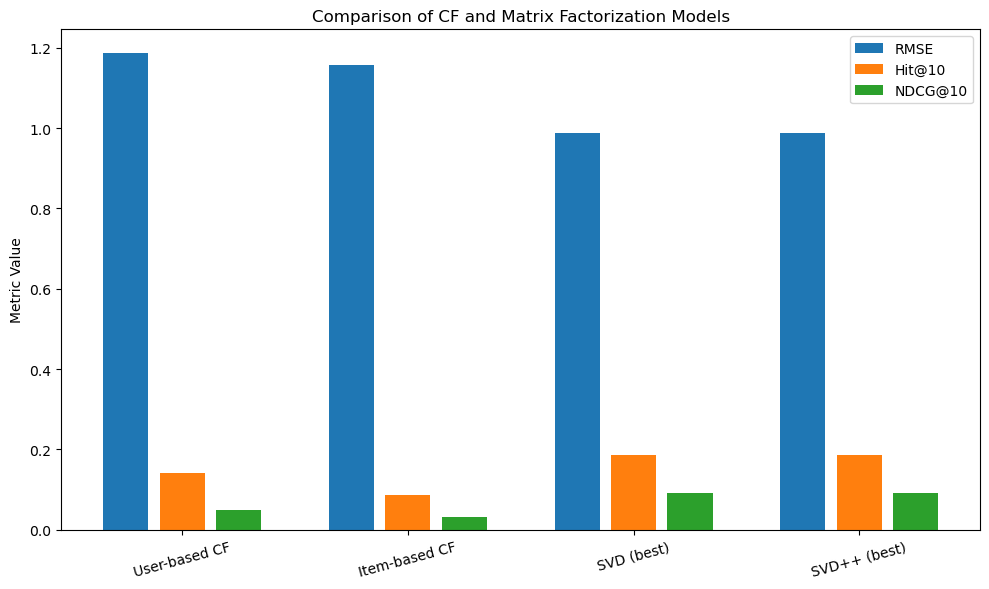

In [16]:
import matplotlib.pyplot as plt

# Data
models = ['User-based CF', 'Item-based CF', 'SVD (best)', 'SVD++ (best)']
rmse = [1.1868, 1.1570, 0.9873, 0.9878]
hit10 = [0.1420, 0.0858, 0.1857, 0.1850]
ndcg10 = [0.0504, 0.0321, 0.0917, 0.0918]

x = range(len(models))

# Plot
plt.figure(figsize=(10,6))
plt.bar(x, rmse, width=0.2, label='RMSE', align='center')
plt.bar([i + 0.25 for i in x], hit10, width=0.2, label='Hit@10', align='center')
plt.bar([i + 0.5 for i in x], ndcg10, width=0.2, label='NDCG@10', align='center')

plt.xticks([i + 0.25 for i in x], models, rotation=15)
plt.ylabel('Metric Value')
plt.title('Comparison of CF and Matrix Factorization Models')
plt.legend()
plt.tight_layout()

# Save figure
plt.show()


## PART 4



TASK 4: COVERAGE vs ACCURACY
     Model  HitRate@10  Coverage@10
Popularity    0.044040     0.000648
  User-kNN    0.143897     0.972978
  Item-kNN    0.085939     0.997214
       SVD    0.185653     0.321280
     SVD++    0.185011     0.341109


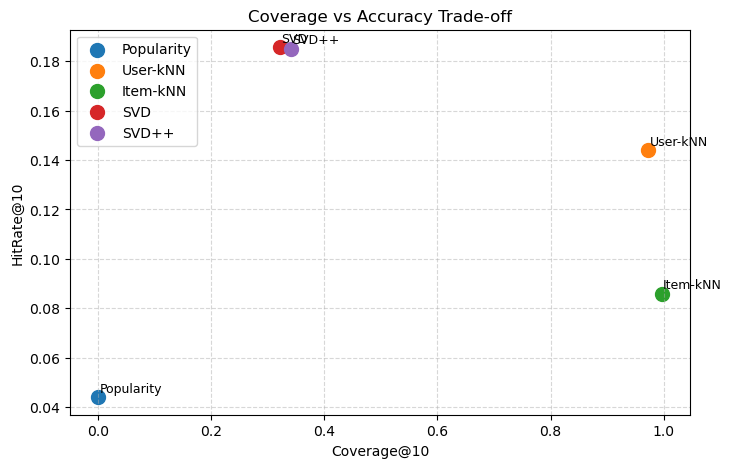


Discussion:
- Popularity baseline has very low coverage but can capture a few hits; it over-recommends popular items.
- User-kNN and Item-kNN cover almost all items, spreading recommendations widely but with lower accuracy.
- SVD and SVD++ provide a balance between accuracy and coverage: moderate coverage with high HitRate.
- This illustrates the trade-off between accuracy (HitRate) and diversity (Coverage) in recommender systems.


In [18]:
# =============================== 
# 🧩 TASK 4 – Coverage vs Accuracy Trade-off
# ===============================

import matplotlib.pyplot as plt
from collections import defaultdict
from heapq import nlargest
import pandas as pd

# -------------------------------
# Coverage@K function
# -------------------------------
def coverage_at_k(predictions, all_items, k=10):
    """
    Fraction of unique items appearing in top-K recommendations across all users.
    """
    preds_by_user = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        preds_by_user[uid].append((iid, est))

    recommended_items = set()
    for user_preds in preds_by_user.values():
        top_items = [iid for iid, _ in nlargest(k, user_preds, key=lambda x: x[1])]
        recommended_items.update(top_items)

    return len(recommended_items) / len(all_items) if all_items else 0.0


# Popularity baseline
item_popularity = df.groupby('item')['rating'].count().sort_values(ascending=False)
top_items_pop = item_popularity.head(10).index

coverage_pop = len(top_items_pop) / len(all_items)

# Compute HitRate@10 for popularity baseline
test_items = [iid for _, iid, *_ in test_ratings]
hit_pop = sum(iid in top_items_pop for iid in test_items) / len(test_items)


# -------------------------------
# CF models (User/Item kNN)
# -------------------------------
coverage_user = coverage_at_k(predictions_user, all_items, k=10)
coverage_item = coverage_at_k(predictions_item, all_items, k=10)

# -------------------------------
# Matrix Factorization models
# -------------------------------
predictions_svd = predict_with_negatives(best_svd_model, test_ratings, num_negatives=99)
predictions_svdpp = predict_with_negatives(best_svdpp_model, test_ratings, num_negatives=99)

coverage_svd = coverage_at_k(predictions_svd, all_items, k=10)
coverage_svdpp = coverage_at_k(predictions_svdpp, all_items, k=10)

# -------------------------------
# Combine Results
# -------------------------------
coverage_results = pd.DataFrame({
    "Model": ["Popularity", "User-kNN", "Item-kNN", "SVD", "SVD++"],
    "HitRate@10": [hit_pop, hit_user, hit_item, best_svd_results['hit_rate'], best_svdpp_results['hit_rate']],
    "Coverage@10": [coverage_pop, coverage_user, coverage_item, coverage_svd, coverage_svdpp]
})

print("\n" + "="*70)
print("TASK 4: COVERAGE vs ACCURACY")
print("="*70)
print(coverage_results.to_string(index=False))

# -------------------------------
# Plot: HitRate vs Coverage
# -------------------------------
plt.figure(figsize=(8, 5))
for _, row in coverage_results.iterrows():
    plt.scatter(row["Coverage@10"], row["HitRate@10"], label=row["Model"], s=100)
    plt.text(row["Coverage@10"] + 0.002, row["HitRate@10"] + 0.002, row["Model"], fontsize=9)

plt.xlabel("Coverage@10")
plt.ylabel("HitRate@10")
plt.title("Coverage vs Accuracy Trade-off")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# -------------------------------
# Discussion
# -------------------------------
print("\nDiscussion:")
print("- Popularity baseline has very low coverage but can capture a few hits; it over-recommends popular items.")
print("- User-kNN and Item-kNN cover almost all items, spreading recommendations widely but with lower accuracy.")
print("- SVD and SVD++ provide a balance between accuracy and coverage: moderate coverage with high HitRate.")
print("- This illustrates the trade-off between accuracy (HitRate) and diversity (Coverage) in recommender systems.")

## Part 5


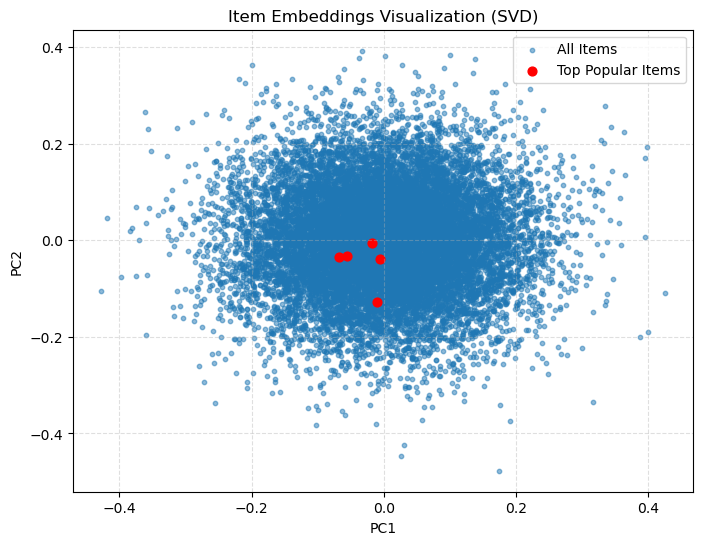

In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# -------------------------------
# 1️⃣ Extract item embeddings
# -------------------------------
# SVD / SVD++ item-factor matrices
item_embeddings_svd = best_svd_model.qi
item_embeddings_svdpp = best_svdpp_model.qi

# Map internal IDs to raw item IDs
item_raw_ids = [trainset.to_raw_iid(iid) for iid in range(len(item_embeddings_svd))]

# -------------------------------
# 2️⃣ Dimensionality reduction (PCA)
# -------------------------------
pca = PCA(n_components=2)
item_embeddings_2d = pca.fit_transform(item_embeddings_svd)

# Optional: t-SNE version (commented)
# tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# item_embeddings_2d = tsne.fit_transform(item_embeddings_svd)

# -------------------------------
# 3️⃣ Plot the embeddings
# -------------------------------
plt.figure(figsize=(8,6))
plt.scatter(item_embeddings_2d[:,0], item_embeddings_2d[:,1], alpha=0.5, s=10, label="All Items")

# Highlight popular items in red
popular_indices = [item_raw_ids.index(i) for i in top_items if i in item_raw_ids]
plt.scatter(item_embeddings_2d[popular_indices,0],
            item_embeddings_2d[popular_indices,1],
            s=40, color='red', label="Top Popular Items")

plt.title("Item Embeddings Visualization (SVD)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

